In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from ipypb import irange

from DataProcessor import DataProcessor
from seq_mf import get_scores_generator, fit_restricted
from evaluation import evaluate, evaluation_callback

# Load and preprocess the data:

In [2]:
data_file_name = "lsapp.csv"

process_data = DataProcessor(
    data_file_name,
    column_names='userid,appid,timestamp',
    session_break_delta='15min',
)

process_data.prepare_data(
    usecols=['userid', 'appid', 'timestamp'],
    test_interval='14d',
    valid_interval='7d',
    min_sess_length=2,
    window="3s",
)

# Define user-contex matrix:
uid2Sui = process_data.get_users_sui(process_data.train, level='userid')

# Gridsearch the model:

In [4]:
from itertools import product

rank_range = [32, 128, 256]
gamma_range = [0.5, 1, 2]
gain_range = [5e-5, 1e-4]
niter_range = [1, 10]
reg_range = [1e-3, 1e-2, 1e-1, 1]
eta_usage = [True, False]
c0 = 1
seed = 13
show_result = True

grid = product(rank_range, gamma_range, gain_range, niter_range, reg_range, eta_usage)

best_params = None
best_hr = 0.0
for n_factors, gamma, gain, n_iter, regularization, eta_bool in grid:
    Cui = process_data.get_freqs(process_data.train, c0=c0, gamma=gamma)

    local_factors, global_factors = fit_restricted(
        Cui,
        uid2Sui,
        n_factors,
        regularization,
        gain,
        n_iter=n_iter,
        seed=seed,
        evaluation_callback=None,
        iterator=range,
        use_eta=eta_bool,
    )
    up_generate_scores = get_scores_generator(local_factors, global_factors)
    metrics_df, user_stats = evaluate(
        up_generate_scores,
        process_data.valid_sessions,
        process_data.seen_interactions,
    )
    valid_results = (
        metrics_df
        .reset_index()
        .groupby(["topk"])
        .mean()[["hr", "mrr", "ndcg"]]
    )
    hr = valid_results["hr"][5]

    if hr > best_hr:
        best_hr = hr
        best_params = (n_factors, gamma, gain, n_iter, regularization, eta_bool)
        if show_result:
            print(
                f"SeqMF:"
                + f"\nBest HR@5: {best_hr}; MRR@5: {valid_results['mrr'][5]}"
                + f"\nThe best performance parameters:"
                + f'\nn_factors={n_factors}, gamma={gamma}, lr={gain}, niter={n_iter}, reg={regularization}, eta={eta_bool}'
            ) 

SeqMF:
Best HR@5: 0.7023340271697435; MRR@5: 0.4349034534864815
The best performance parameters:
n_factors=32, gamma=0.5, lr=5e-05, niter=1, reg=0.001, eta=True
SeqMF:
Best HR@5: 0.7697010922614509; MRR@5: 0.4925002059845813
The best performance parameters:
n_factors=32, gamma=1, lr=5e-05, niter=1, reg=0.001, eta=True


/home/albert/.local/lib/python3.9/site-packages/numpy/core/_methods.py:47: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/home/albert/rec_sys_project/seq_mf.py:77: RuntimeWarning: overflow encountered in multiply
  seq_part *= eta[u]


SeqMF:
Best HR@5: 0.7848824003950404; MRR@5: 0.5038752286075311
The best performance parameters:
n_factors=128, gamma=0.5, lr=5e-05, niter=1, reg=0.001, eta=True
SeqMF:
Best HR@5: 0.793508054171779; MRR@5: 0.5127899042142385
The best performance parameters:
n_factors=128, gamma=0.5, lr=5e-05, niter=1, reg=0.01, eta=False
SeqMF:
Best HR@5: 0.8017386649263595; MRR@5: 0.5265386222241286
The best performance parameters:
n_factors=128, gamma=1, lr=5e-05, niter=1, reg=0.001, eta=False
SeqMF:
Best HR@5: 0.8056139798316259; MRR@5: 0.5256801856527482
The best performance parameters:
n_factors=128, gamma=1, lr=0.0001, niter=1, reg=0.001, eta=False
SeqMF:
Best HR@5: 0.8159196613376648; MRR@5: 0.5258594705746472
The best performance parameters:
n_factors=256, gamma=0.5, lr=5e-05, niter=1, reg=0.001, eta=True
SeqMF:
Best HR@5: 0.8205783505277496; MRR@5: 0.5278234205414835
The best performance parameters:
n_factors=256, gamma=1, lr=5e-05, niter=1, reg=0.001, eta=True


/home/albert/rec_sys_project/seq_mf.py:95: RuntimeWarning: overflow encountered in multiply
  return longterm_grad + eta[u] * sessions_grad
/home/albert/rec_sys_project/seq_mf.py:54: RuntimeWarning: overflow encountered in add
  grad += gradient_update(user)
/home/albert/.local/lib/python3.9/site-packages/numpy/core/numeric.py:942: RuntimeWarning: overflow encountered in multiply
  return multiply(a.ravel()[:, newaxis], b.ravel()[newaxis, :], out)


In [5]:
n_factors, gamma, gain, n_iter, regularization, eta_bool = best_params

Cui = process_data.get_freqs(process_data.train, c0=c0, gamma=gamma)

local_factors, global_factors = fit_restricted(
    Cui,
    uid2Sui,
    n_factors,
    regularization,
    gain,
    n_iter=n_iter,
    seed=seed,
    evaluation_callback=None,
    iterator=range,
    use_eta=eta_bool,
)
up_generate_scores = get_scores_generator(local_factors, global_factors)

metrics_df, user_stats = evaluate(
    up_generate_scores,
    process_data.test_sessions,
    process_data.seen_interactions,
)

test_results = (
    metrics_df
    .reset_index()
    .groupby(["topk"])
    .mean()[["hr", "mrr", "ndcg"]]
)

test_results

metrics,hr,mrr,ndcg
topk,,,
1,0.408695,0.408695,0.408695
3,0.645289,0.509801,0.544464
5,0.755680,0.534879,0.589798


In [6]:
def get_scores_generator_4(local_factors, global_factors):
    P, eta = local_factors
    Q, Qb = global_factors
    def generate_scores(uid, sid, sess_items, item_pool):
        scores = Q[item_pool] @ Q[sess_items].sum(axis=0)
        return scores 
    return generate_scores

up_generate_scores = get_scores_generator_4(local_factors, global_factors)

metrics_df, user_stats = evaluate(
    up_generate_scores,
    process_data.test_sessions,
    process_data.seen_interactions,
)

test_results = (
    metrics_df
    .reset_index()
    .groupby(["topk"])
    .mean()[["hr", "mrr", "ndcg"]]
)

test_results

metrics,hr,mrr,ndcg
topk,,,
1,0.538112,0.538112,0.538112
3,0.807392,0.659791,0.697827
5,0.879121,0.676431,0.727587


In [ ]:
assert False

# Train the model:

In [3]:
smf_callback = evaluation_callback(
    get_scores_generator,
    process_data.valid_sessions,
    process_data.seen_interactions, 
    factor_names=["ULF", "CLF", "IGF", "CGF"],
)

n_factors = 256
regularization = 0.001
gain = 1e-4
seed = 13
n_iter = 15
c0 = 1.0
gamma = 1.0

Cui = process_data.get_freqs(process_data.train, c0=c0, gamma=gamma)

local_factors, global_factors = fit_restricted(
    Cui,
    uid2Sui,
    n_factors,
    regularization,
    gain,
    n_iter=n_iter,
    seed=seed,
    evaluation_callback=smf_callback,
    iterator=irange,
    use_eta=True,
)

 [████████████████████████████████████████████████████████████] 15/15 [00:08<00:01, 0.53s/it]

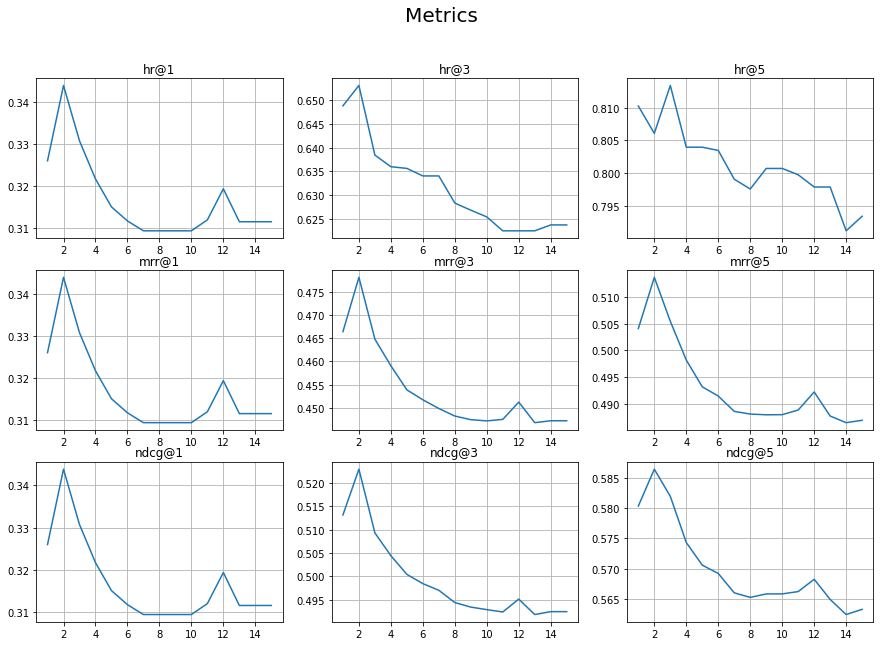

In [4]:
plt.rcParams["figure.figsize"] = (15, 10)

epochs = np.arange(1, n_iter + 1)
stat_metrics = list(smf_callback.stat.keys())[:-1]
topk = smf_callback.stat[stat_metrics[0]].keys()

fig, axs = plt.subplots(3, 3)
fig.suptitle("Metrics", fontsize=20)
for i, metric in enumerate(stat_metrics):
    for j, k in enumerate(topk):
        axs[i, j].plot(epochs, smf_callback.stat[metric][k])
        axs[i, j].set_title(f"{metric}@{k}")
        axs[i, j].grid(True)

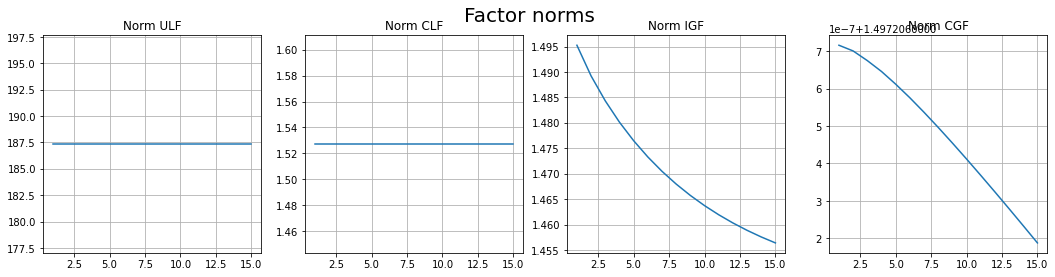

In [5]:
plt.rcParams["figure.figsize"] = (18, 4)
model_metrics = smf_callback.stat["norms"].keys()

fig, axs = plt.subplots(1, 4)
fig.suptitle("Factor norms", fontsize=20)
for j, name in enumerate(model_metrics):
    axs[j].plot(epochs, smf_callback.stat["norms"][name])
    axs[j].set_title(f"Norm {name}")
    axs[j].grid(True)

# Evaluation:

## Long-term + Short-term:

In [6]:
up_generate_scores = get_scores_generator(local_factors, global_factors)

metrics_df, user_stats = evaluate(
    up_generate_scores,
    process_data.test_sessions,
    process_data.seen_interactions,
)

test_results = (
    metrics_df
    .reset_index()
    .groupby(["topk"])
    .mean()[["hr", "mrr", "ndcg"]]
)

test_results

metrics,hr,mrr,ndcg
topk,,,
1,0.402657,0.402657,0.402657
3,0.646238,0.507336,0.542897
5,0.762958,0.534880,0.591732


## Only Long-Term:

In [7]:
def get_scores_generator_1(local_factors, global_factors):
    P, eta = local_factors
    Q, Qb = global_factors
    def generate_scores(uid, sid, sess_items, item_pool):
        scores = P[uid] @ Q[item_pool].T
        return scores 
    return generate_scores

up_generate_scores = get_scores_generator_1(local_factors, global_factors)

metrics_df, user_stats = evaluate(
    up_generate_scores,
    process_data.test_sessions,
    process_data.seen_interactions,
)

test_results = (
    metrics_df
    .reset_index()
    .groupby(["topk"])
    .mean()[["hr", "mrr", "ndcg"]]
)

test_results

metrics,hr,mrr,ndcg
topk,,,
1,0.402657,0.402657,0.402657
3,0.646238,0.507336,0.542897
5,0.762958,0.534898,0.591748


## Only Short-Term:

In [8]:
def get_scores_generator_2(local_factors, global_factors):
    P, eta = local_factors
    Q, Qb = global_factors
    def generate_scores(uid, sid, sess_items, item_pool):
        scores = Qb[sess_items[-1]] @ Q[item_pool].T
        return scores 
    return generate_scores

up_generate_scores = get_scores_generator_2(local_factors, global_factors)

metrics_df, user_stats = evaluate(
    up_generate_scores,
    process_data.test_sessions,
    process_data.seen_interactions,
)

test_results = (
    metrics_df
    .reset_index()
    .groupby(["topk"])
    .mean()[["hr", "mrr", "ndcg"]]
)

test_results

metrics,hr,mrr,ndcg
topk,,,
1,0.154825,0.154825,0.154825
3,0.328013,0.233809,0.258116
5,0.422940,0.255696,0.297382


## Like in SVD:

In [9]:
def get_scores_generator_4(local_factors, global_factors):
    P, eta = local_factors
    Q, Qb = global_factors
    def generate_scores(uid, sid, sess_items, item_pool):
        scores = Q[item_pool] @ Q[sess_items].sum(axis=0)
        return scores 
    return generate_scores

up_generate_scores = get_scores_generator_4(local_factors, global_factors)

metrics_df, user_stats = evaluate(
    up_generate_scores,
    process_data.test_sessions,
    process_data.seen_interactions,
)

test_results = (
    metrics_df
    .reset_index()
    .groupby(["topk"])
    .mean()[["hr", "mrr", "ndcg"]]
)

test_results

metrics,hr,mrr,ndcg
topk,,,
1,0.546542,0.546542,0.546542
3,0.827861,0.673823,0.713525
5,0.890445,0.688328,0.739478


## Only Q and last one from session:

In [10]:
def get_scores_generator_3(local_factors, global_factors):
    P, eta = local_factors
    Q, Qb = global_factors
    def generate_scores(uid, sid, sess_items, item_pool):
        scores = Q[item_pool] @ Q[sess_items[-1]]
        return scores 
    return generate_scores

up_generate_scores = get_scores_generator_3(local_factors, global_factors)

metrics_df, user_stats = evaluate(
    up_generate_scores,
    process_data.test_sessions,
    process_data.seen_interactions,
)

test_results = (
    metrics_df
    .reset_index()
    .groupby(["topk"])
    .mean()[["hr", "mrr", "ndcg"]]
)

test_results

metrics,hr,mrr,ndcg
topk,,,
1,0.616732,0.616732,0.616732
3,0.719164,0.661294,0.676132
5,0.794454,0.678716,0.707330


In [11]:
def get_scores_generator_5(local_factors, global_factors):
    P, eta = local_factors
    Q, Qb = global_factors
    par = 1
    if eta is not None:
        def generate_scores(uid, sid, sess_items, item_pool):
            k_back = min(len(sess_items), par) 
            scores = Q[item_pool] @ (P[uid] + eta[uid] * Qb[sess_items[:]].sum(axis=0))
            return scores
        return generate_scores

    def generate_scores(uid, sid, sess_items, item_pool):
        k_back = min(len(sess_items), par) 
        scores = Q[item_pool] @ (P[uid] + Qb[sess_items[-k_back:]].sum(axis=0))
        return scores
    return generate_scores

In [12]:
up_generate_scores = get_scores_generator_5(local_factors, global_factors)

metrics_df, user_stats = evaluate(
    up_generate_scores,
    process_data.test_sessions,
    process_data.seen_interactions,
)

test_results = (
    metrics_df
    .reset_index()
    .groupby(["topk"])
    .mean()[["hr", "mrr", "ndcg"]]
)

test_results

metrics,hr,mrr,ndcg
topk,,,
1,0.400761,0.400761,0.400761
3,0.645818,0.504612,0.540702
5,0.763005,0.532226,0.589697
